Learning to rank.


In [1]:
# set up Python
import os
import logging
import numpy as np
import pandas as pd
import json
from sklearn.linear_model import LogisticRegression
from cmdstanpy import CmdStanModel
from plotnine import *
from rank_plotting_fns import plot_rank_performance

# quiet down Stan
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())


In [2]:
rng = np.random.default_rng(383432)


In [3]:
example_name = 'uci wine example'


In [4]:
print(example_name)


uci wine example


In [5]:
if example_name=='uci wine example':
    # read data and set scale of system
    features_frame = pd.read_csv('uci_wine_example_features.csv')
    features_scores = pd.read_csv('uci_wine_example_scores.csv')
    score_name = 'logistic_score'
    m_examples : int = 100
    noise_scale = 3.87
    position_penalty_scale = -2.7123
elif example_name=='sklearn wine example':
    # read data and set scale of system
    features_frame = pd.read_csv('sklearn_wine_example_features.csv')
    features_scores = pd.read_csv('sklearn_wine_example_scores.csv')
    score_name = 'score'
    m_examples : int = 100
    noise_scale = 18.7
    position_penalty_scale = -13.123
else:
    raise("bad option")


In [6]:
features_frame.head()


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [7]:
features_frame.shape


(6497, 11)

In [8]:
n_alternatives : int = 5


In [9]:
position_penalties = [position_penalty_scale * i for i in range(n_alternatives)]

position_penalties


[-0.0, -2.7123, -5.4246, -8.1369, -10.8492]

In [10]:
n_vars : int = features_frame.shape[1] + len(position_penalties)

# assemble panels of observations with top scoring entry picked
observations = dict()
for sel_i in range(n_alternatives):
    observations[f'display_position_{sel_i}'] = [sel_i] * m_examples
    selected_examples = rng.choice(features_frame.shape[0], size=m_examples, replace=True)
    observations[f'item_id_{sel_i}'] = selected_examples
    observations[f'score_value_{sel_i}'] = [  # noisy observation of score plus position penalty
        features_scores.loc[int(selected_examples[i]), score_name]               # item score
        + position_penalties[sel_i]                                              # positional penalty
        + noise_scale * rng.normal(size=1)[0]                                    # observation noise
        for i in range(m_examples)
    ]
    observations[f'pick_value_{sel_i}'] = [0] * m_examples
observations = pd.DataFrame(observations)
# mark selections
for i in range(m_examples):
    best_j = 0
    for j in range(1, n_alternatives):
        if observations[f'score_value_{j}'][i] > observations[f'score_value_{best_j}'][i]:
            best_j = j
    observations.loc[i, f'pick_value_{best_j}'] = 1

observations.head()


,display_position_0,item_id_0,score_value_0,pick_value_0,display_position_1,item_id_1,score_value_1,pick_value_1,display_position_2,item_id_2,score_value_2,pick_value_2,display_position_3,item_id_3,score_value_3,pick_value_3,display_position_4,item_id_4,score_value_4,pick_value_4
0,0,4851,6.895743,0,1,2043,8.561434,1,2,5998,-1.640812,0,3,2851,5.239945,0,4,1732,3.182904,0
1,0,1458,12.461274,1,1,4352,12.220664,0,2,2073,-0.194450,0,3,2626,5.206970,0,4,404,-3.866103,0
2,0,4943,5.945032,0,1,259,18.252708,1,2,1352,11.700698,0,3,2626,0.401804,0,4,1238,2.639090,0
3,0,1900,10.685086,0,1,2326,13.824795,1,2,3841,4.060704,0,3,2995,4.362948,0,4,6104,0.748428,0
4,0,5569,12.160221,0,1,6215,13.531224,1,2,3283,8.360968,0,3,618,7.816043,0,4,1086,2.379892,0


In [11]:
observations.loc[:, [c for c in observations.columns if c.startswith('pick_value_')]].mean(axis=0)


pick_value_0    0.66
pick_value_1    0.25
pick_value_2    0.08
pick_value_3    0.00
pick_value_4    0.01
dtype: float64

In [12]:
observations[
    [c for c in observations.columns if (not c.startswith('score_value_')) and (not c.startswith('item_id_'))]
    ].head(10)


,display_position_0,pick_value_0,display_position_1,pick_value_1,display_position_2,pick_value_2,display_position_3,pick_value_3,display_position_4,pick_value_4
0,0,0,1,1,2,0,3,0,4,0
1,0,1,1,0,2,0,3,0,4,0
2,0,0,1,1,2,0,3,0,4,0
3,0,0,1,1,2,0,3,0,4,0
4,0,0,1,1,2,0,3,0,4,0
5,0,1,1,0,2,0,3,0,4,0
6,0,1,1,0,2,0,3,0,4,0
7,0,1,1,0,2,0,3,0,4,0
8,0,1,1,0,2,0,3,0,4,0
9,0,0,1,1,2,0,3,0,4,0


In [13]:
# This is the data
observations[
    [c for c in observations.columns if (not c.startswith('score_value_')) and (not c.startswith('item_id_')) and (not c.startswith('display_position_'))]
    ].head(10)


,pick_value_0,pick_value_1,pick_value_2,pick_value_3,pick_value_4
0,0,1,0,0,0
1,1,0,0,0,0
2,0,1,0,0,0
3,0,1,0,0,0
4,0,1,0,0,0
5,1,0,0,0,0
6,1,0,0,0,0
7,1,0,0,0,0
8,1,0,0,0,0
9,0,1,0,0,0


In [14]:
score_compare_frame = pd.DataFrame({
    'hidden concept': features_scores[score_name],
})


Try a Stan model.


In [15]:
# swap all observed alternatives selections into picked position
observations_sorted = observations.copy()
for passed_i in range(1, n_alternatives):
    for row_i in range(m_examples):
        if observations_sorted.loc[row_i, f'pick_value_{passed_i}'] > 0:
            # swap where data is stored in row
            for dest_col, source_col in (
                ('display_position_0', f'display_position_{passed_i}'),
                ('item_id_0', f'item_id_{passed_i}'),
                ('score_value_0', f'score_value_{passed_i}'),
                ('pick_value_0', f'pick_value_{passed_i}'),
                ):
                v_source = observations_sorted.loc[row_i, source_col]
                v_dest = observations_sorted.loc[row_i, dest_col]
                observations_sorted.loc[row_i, source_col] = v_dest
                observations_sorted.loc[row_i, dest_col] = v_source


In [16]:
observations_sorted.head(10)


,display_position_0,item_id_0,score_value_0,pick_value_0,display_position_1,item_id_1,score_value_1,pick_value_1,display_position_2,item_id_2,score_value_2,pick_value_2,display_position_3,item_id_3,score_value_3,pick_value_3,display_position_4,item_id_4,score_value_4,pick_value_4
0,1,2043,8.561434,1,0,4851,6.895743,0,2,5998,-1.640812,0,3,2851,5.239945,0,4,1732,3.182904,0
1,0,1458,12.461274,1,1,4352,12.220664,0,2,2073,-0.194450,0,3,2626,5.206970,0,4,404,-3.866103,0
2,1,259,18.252708,1,0,4943,5.945032,0,2,1352,11.700698,0,3,2626,0.401804,0,4,1238,2.639090,0
3,1,2326,13.824795,1,0,1900,10.685086,0,2,3841,4.060704,0,3,2995,4.362948,0,4,6104,0.748428,0
4,1,6215,13.531224,1,0,5569,12.160221,0,2,3283,8.360968,0,3,618,7.816043,0,4,1086,2.379892,0
5,0,1997,16.874651,1,1,3764,8.886813,0,2,2909,6.086745,0,3,1157,8.669195,0,4,5434,-0.658782,0
6,0,4473,11.916911,1,1,4949,11.453184,0,2,152,6.217401,0,3,486,-0.883631,0,4,4638,0.263761,0
7,0,959,16.757090,1,1,2918,6.925173,0,2,397,9.362681,0,3,6430,0.681281,0,4,2846,8.329044,0
8,0,4516,14.924389,1,1,4051,12.342308,0,2,1208,8.405716,0,3,5926,7.133246,0,4,4976,-0.947289,0
9,1,3324,10.545777,1,0,933,8.579031,0,2,2538,10.329640,0,3,4624,1.240109,0,4,918,1.669653,0


In [17]:
observations_sorted[
    [c for c in observations_sorted.columns if (not c.startswith('score_value_')) and (not c.startswith('item_id_'))]
    ].head(10)


,display_position_0,pick_value_0,display_position_1,pick_value_1,display_position_2,pick_value_2,display_position_3,pick_value_3,display_position_4,pick_value_4
0,1,1,0,0,2,0,3,0,4,0
1,0,1,1,0,2,0,3,0,4,0
2,1,1,0,0,2,0,3,0,4,0
3,1,1,0,0,2,0,3,0,4,0
4,1,1,0,0,2,0,3,0,4,0
5,0,1,1,0,2,0,3,0,4,0
6,0,1,1,0,2,0,3,0,4,0
7,0,1,1,0,2,0,3,0,4,0
8,0,1,1,0,2,0,3,0,4,0
9,1,1,0,0,2,0,3,0,4,0


In [18]:
observations_sorted[
    [c for c in observations_sorted.columns if (not c.startswith('score_value_')) and (not c.startswith('item_id_')) and (not c.startswith('pick_value_'))]
    ].head(10)


,display_position_0,display_position_1,display_position_2,display_position_3,display_position_4
0,1,0,2,3,4
1,0,1,2,3,4
2,1,0,2,3,4
3,1,0,2,3,4
4,1,0,2,3,4
5,0,1,2,3,4
6,0,1,2,3,4
7,0,1,2,3,4
8,0,1,2,3,4
9,1,0,2,3,4


In [19]:
assert np.all(observations_sorted['pick_value_0'] == 1)
for sel_i in range(1, n_alternatives):
    assert np.all(observations_sorted[f'pick_value_{sel_i}'] == 0)


In [20]:
stan_model_src = (
"""
data {
  int<lower=1> n_vars;                     // number of variables per alternative
  int<lower=1> m_examples;                 // number of examples
  matrix[m_examples, n_vars] x_picked;     // character of picked examples
"""
  + ''.join([f"""  matrix[m_examples, n_vars] x_passed_{i};   // character of passed examples
""" for i in range(1, n_alternatives)])
  + """}
parameters {
  vector[n_vars] beta;                      // model parameters
  vector[m_examples] error_picked;          // reified noise term on picks (the secret sauce!)
}
transformed parameters {
  vector[m_examples] expect_picked;
  vector[m_examples] v_picked;
"""
  + ''.join([f"""  vector[m_examples] expect_passed_{i};
""" for i in range(1, n_alternatives)])
  + """  expect_picked = x_picked * beta;          // modeled expected score of picked item
  v_picked = expect_picked + error_picked;  // reified actual score of picked item
"""
  + ''.join([f"""  expect_passed_{i} = x_passed_{i} * beta;      // modeled expected score of passed item
""" for i in range(1, n_alternatives)])
  +"""}
model {
    // basic priors
  beta ~ normal(0, 10);
  error_picked ~ normal(0, 10);
    // log probability of observed ordering as a function of parameters
    // terms are independent conditioned on knowing value of v_picked!
"""
  + ''.join([f"""  target += normal_lcdf( v_picked | expect_passed_{i}, 10);
""" for i in range(1, n_alternatives)])
  + """}
"""
)


print(stan_model_src)



data {
  int<lower=1> n_vars;                     // number of variables per alternative
  int<lower=1> m_examples;                 // number of examples
  matrix[m_examples, n_vars] x_picked;     // character of picked examples
  matrix[m_examples, n_vars] x_passed_1;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_2;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_3;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_4;   // character of passed examples
}
parameters {
  vector[n_vars] beta;                      // model parameters
  vector[m_examples] error_picked;          // reified noise term on picks (the secret sauce!)
}
transformed parameters {
  vector[m_examples] expect_picked;
  vector[m_examples] v_picked;
  vector[m_examples] expect_passed_1;
  vector[m_examples] expect_passed_2;
  vector[m_examples] expect_passed_3;
  vector[m_examples] expect_passed_4;
  expect_picked = x_picked * beta;          // mod

In [21]:
def fmt_array(a) -> str:
    return json.dumps([v for v in a])

def mk_posn_indicator(posn: int) -> str:
    posn_indicators = [0] * n_alternatives
    posn_indicators[posn] = 1
    return posn_indicators

def f_i(sel_i: int) -> str:
    id_seq = observations_sorted[f'item_id_{sel_i}']
    posn_seq = observations_sorted[f'display_position_{sel_i}']
    return fmt_array([
        list(features_frame.loc[int(id), :]) + mk_posn_indicator(int(posn))
        for id, posn in zip(id_seq, posn_seq)])

data_str = (f"""
{{
 "n_vars" : {n_vars},
 "m_examples" : {m_examples},
 "x_picked" : {f_i(0)},
"""
    + """,
""".join([f""" "x_passed_{i}" : {f_i(i)}""" for i in range(1, n_alternatives)])
    + """
}
"""
)


In [22]:
# build model
# export sorce and data
stan_file = 'rank_src_tmp.stan'
data_file = "rank_data_tmp.json"
with open(stan_file, 'w', encoding='utf8') as file:
    file.write(stan_model_src)
with open(data_file, 'w', encoding='utf8') as file:
    file.write(data_str)
# instantiate the model object
model = CmdStanModel(stan_file=stan_file)
# fit to data
fit = model.sample(
    data=data_file,
    show_progress=False,
    show_console=False,
)
os.remove(stan_file)
os.remove(data_file)


In [23]:
# get implied sample weights from chain
wt_frame = fit.draws_pd(vars=['lp__'])

wt_frame


,lp__
0,-103.443
1,-117.738
2,-119.960
3,-112.723
4,-104.015
...,...
3995,-118.325
3996,-119.290
3997,-116.206
3998,-134.295


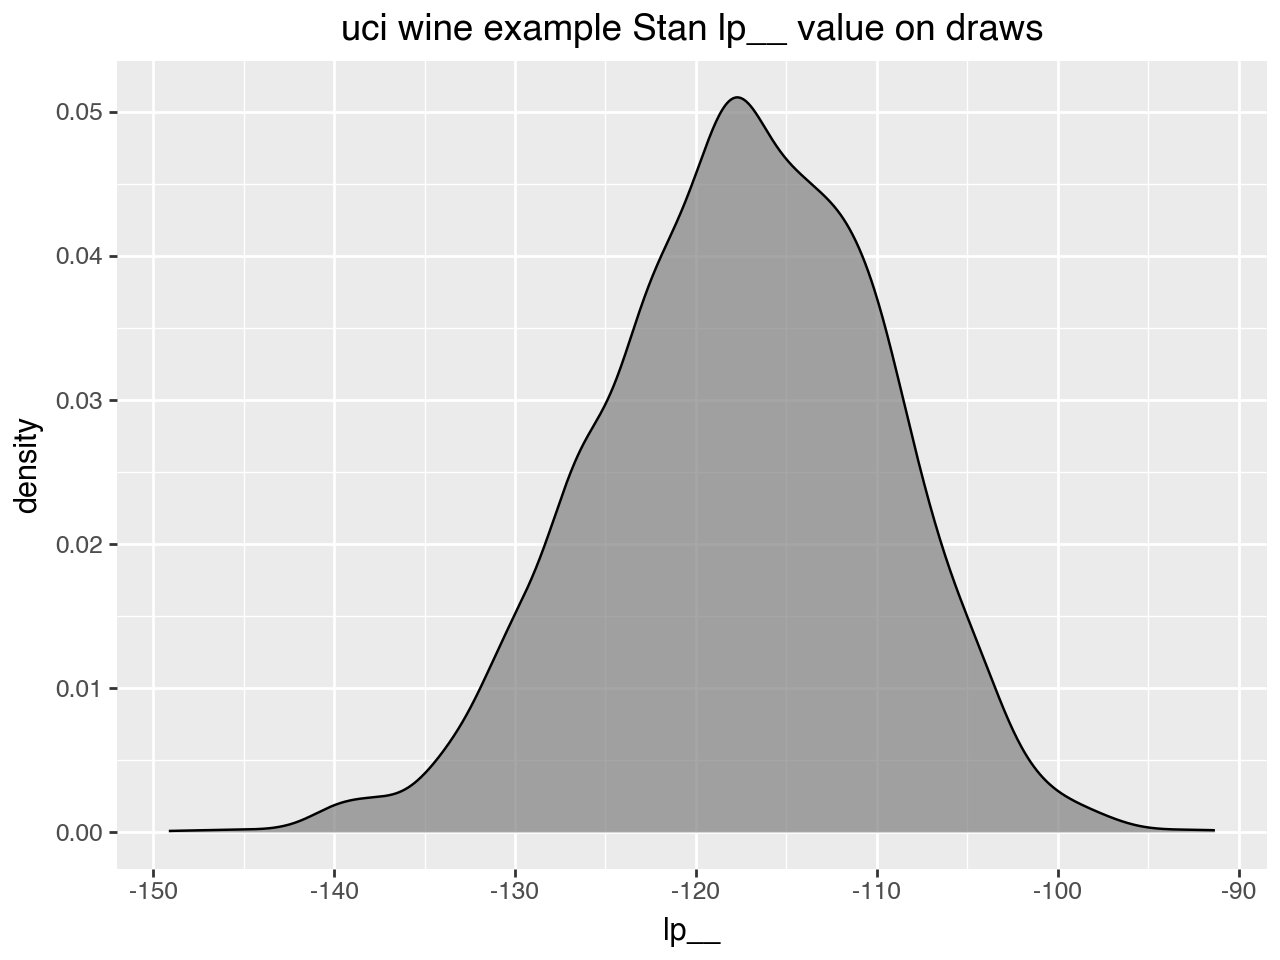

In [24]:
(
    ggplot(
        data=wt_frame,
        mapping=aes(x='lp__'),
    )
    + geom_density(fill='gray', alpha=0.7)
    + ggtitle(f'{example_name} Stan lp__ value on draws')
)


In [25]:
beta_draws = fit.draws_pd(vars=['beta'])
beta_draws_display = beta_draws.copy()
beta_draws_display.columns = list(features_frame.columns) + [f'position_effect_{sel_i}' for sel_i in range(n_alternatives)]

beta_draws_display


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,position_effect_0,position_effect_1,position_effect_2,position_effect_3,position_effect_4
0,-0.254535,-13.58540,-8.619640,-0.000520,14.16230,0.013531,-0.006813,0.249146,1.193050,-2.42555,3.42545,15.1789,10.05310,0.523762,-10.53660,-16.88390
1,-1.112580,-15.56810,-1.021230,0.058903,8.93303,0.080929,-0.005825,25.398200,-1.943320,-3.55069,2.58548,15.5902,10.70450,1.307290,-15.48020,-11.59820
2,-1.245740,-14.73050,-3.977930,-0.478543,-2.42804,-0.067218,0.035700,14.460900,-8.610740,5.80590,4.21069,15.9179,11.27720,5.788280,-9.30108,-17.74570
3,1.222580,-6.12518,-5.120620,-0.210908,7.90726,0.078357,0.034023,-3.291650,4.246410,1.20833,3.96696,16.9515,7.82880,1.225020,-24.69150,-11.74580
4,0.997873,-13.67230,-5.651090,-0.235694,9.82388,0.027575,0.064380,-12.002800,0.024767,4.57672,4.71822,16.7184,10.65080,1.928400,-18.91100,-7.57122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-0.773259,-15.74580,-8.899920,-0.226395,2.61317,-0.200005,0.066629,9.842270,-0.022696,-4.58792,3.68947,18.3836,7.82651,0.966344,-16.48540,-7.08417
3996,2.507590,-4.35395,0.674262,-0.778831,-1.00234,-0.018128,0.056576,-21.133500,-1.922590,-8.37256,1.60407,19.6478,14.41600,-0.167900,-9.27020,-7.46901
3997,-0.557179,-21.71290,-5.564030,-0.011495,7.63938,-0.262133,0.060577,1.589540,-3.560430,-3.49996,3.66971,19.9442,7.99105,4.398210,-14.99210,-8.21087
3998,-0.058849,-1.20371,0.452934,-0.629752,-11.24520,-0.053530,0.066596,-3.285650,-10.181300,1.16537,3.82787,26.3182,21.56300,12.946500,-3.29544,-0.12771


In [26]:
# this this entirety of what we pull out of Stan- per modeled preference cohort
# from now on we do not use Stan
estimated_beta_Stan = beta_draws_display.loc[wt_frame['lp__'] >= np.quantile(wt_frame['lp__'], 0.9), :].mean()
#estimated_beta_Stan = beta_draws_display.mean()
estimated_beta_Stan


fixed_acidity            0.100899
volatile_acidity       -14.500925
citric_acid             -2.173595
residual_sugar          -0.214753
chlorides                1.001708
free_sulfur_dioxide     -0.015716
total_sulfur_dioxide     0.028374
density                  0.289165
pH                      -1.723833
sulphates               -0.740172
alcohol                  2.474061
position_effect_0       15.588366
position_effect_1        7.975169
position_effect_2        0.415927
position_effect_3      -14.527330
position_effect_4      -10.173307
dtype: float64

In [27]:
position_quantiles = (
    beta_draws
        .iloc[:, features_frame.shape[1]:n_vars]
        .quantile((0.25, 0.5, 0.75))
        .transpose()
        .reset_index(drop=True, inplace=False)
)
position_quantiles.columns = [str(c) for c in position_quantiles.columns]


estimated position influences
  position  actual effect  estimated effect       0.25        0.5       0.75
0   posn_0        -0.0000         15.588366  13.048450  16.137350  19.335000
1   posn_1        -2.7123          7.975169   5.009597   8.265395  11.567050
2   posn_2        -5.4246          0.415927  -2.886773   0.522746   3.848370
3   posn_3        -8.1369        -14.527330 -19.846775 -15.490650 -11.288500
4   posn_4       -10.8492        -10.173307 -14.250750 -10.395250  -6.638153


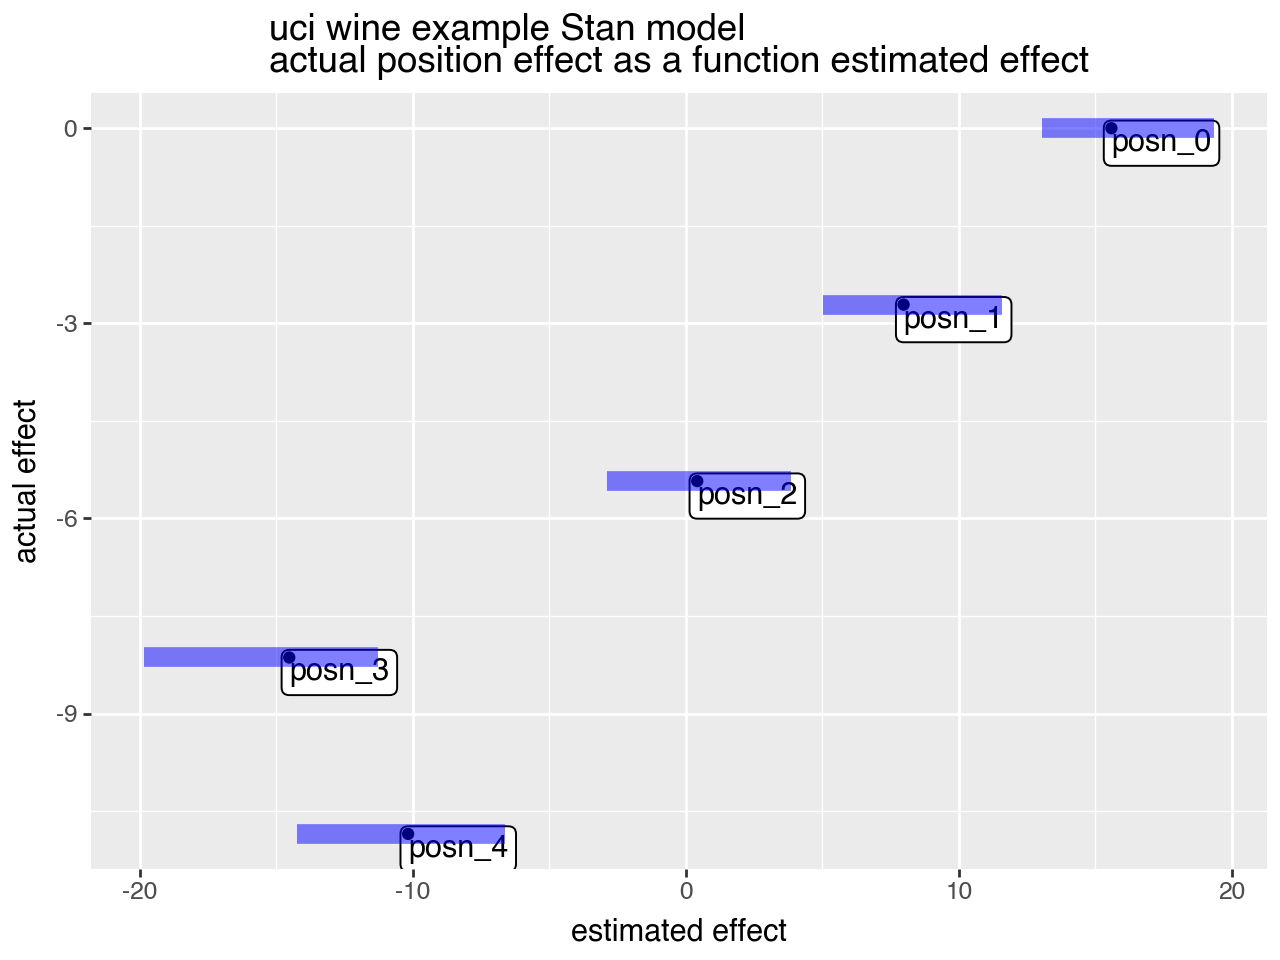

picks
   row  position  pick probability estimate  was pick
0    0         0                     0.8113     False
1    0         1                     0.1557      True
2    0         2                     0.0288     False
3    0         3                     0.0020     False
4    0         4                     0.0022     False
5    1         0                     0.5406      True
6    1         1                     0.3806     False
7    1         2                     0.0775     False
8    1         3                     0.0006     False
9    1         4                     0.0007     False


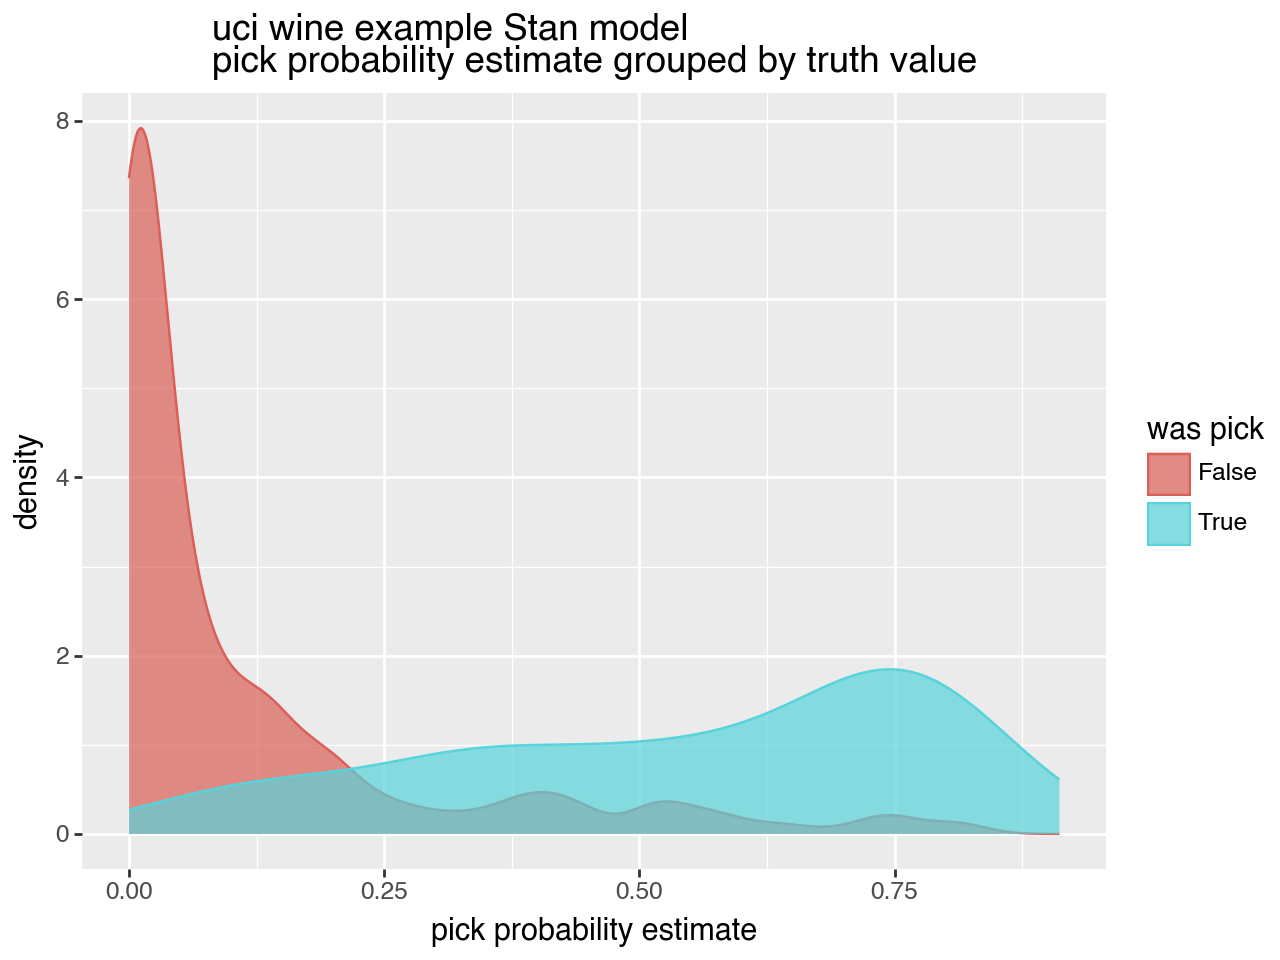

<Figure size 640x480 with 0 Axes>

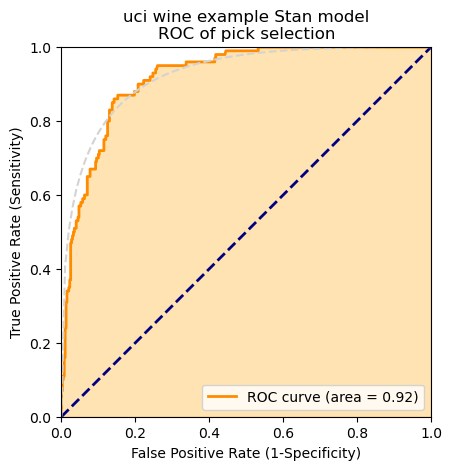

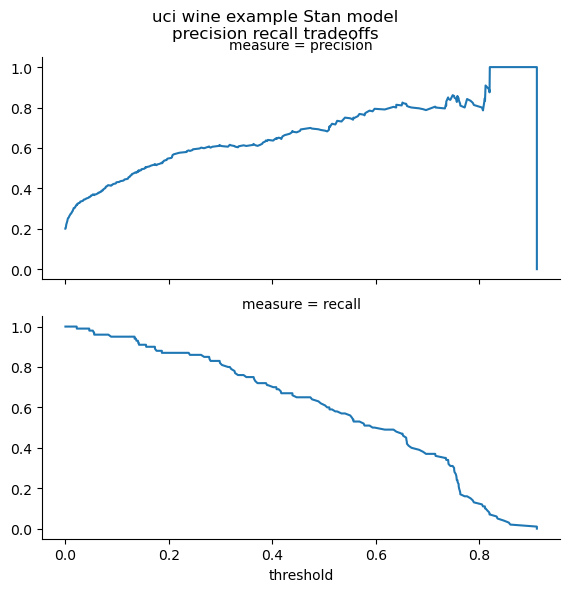

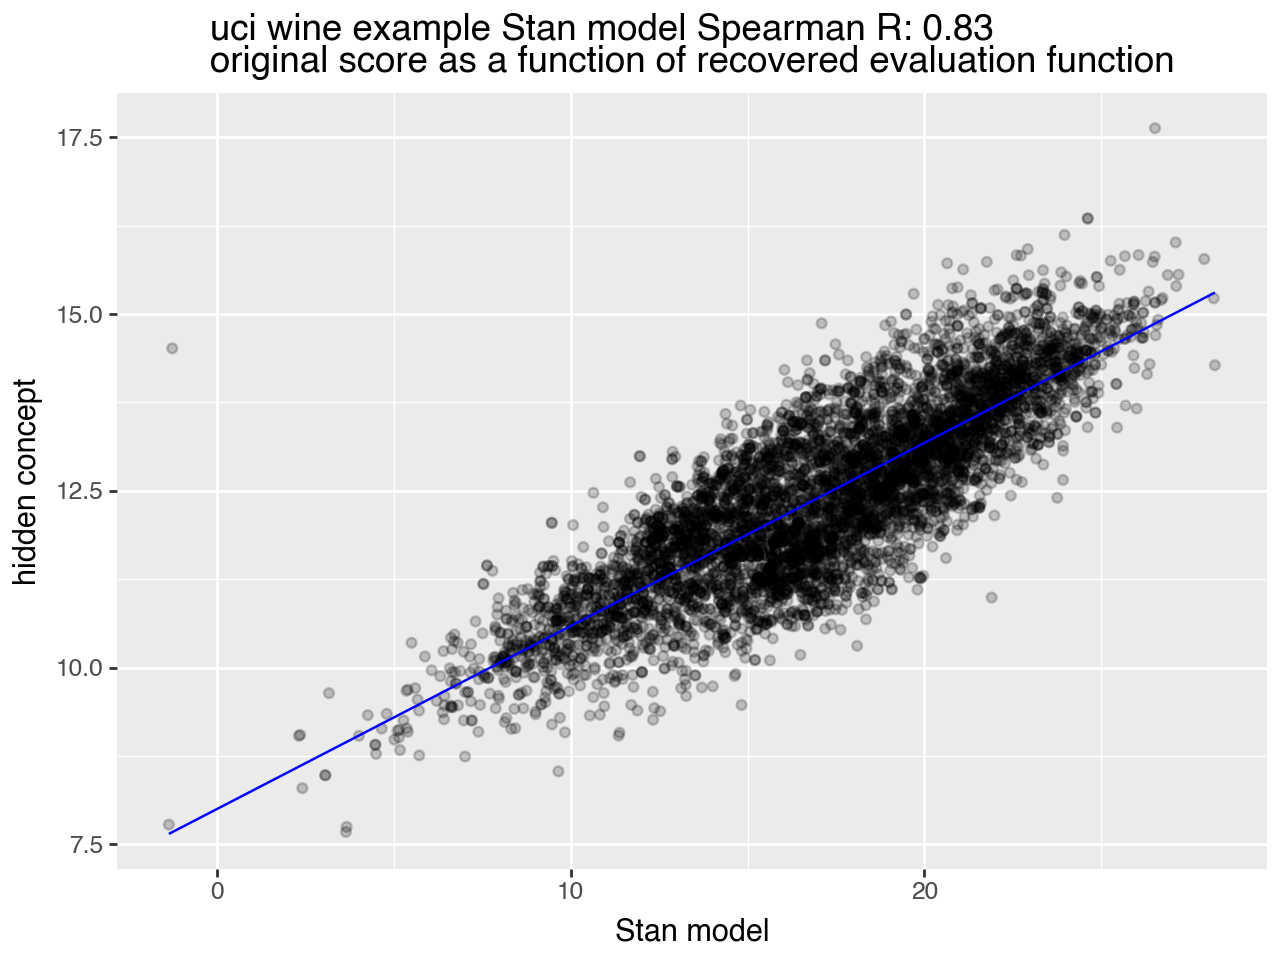

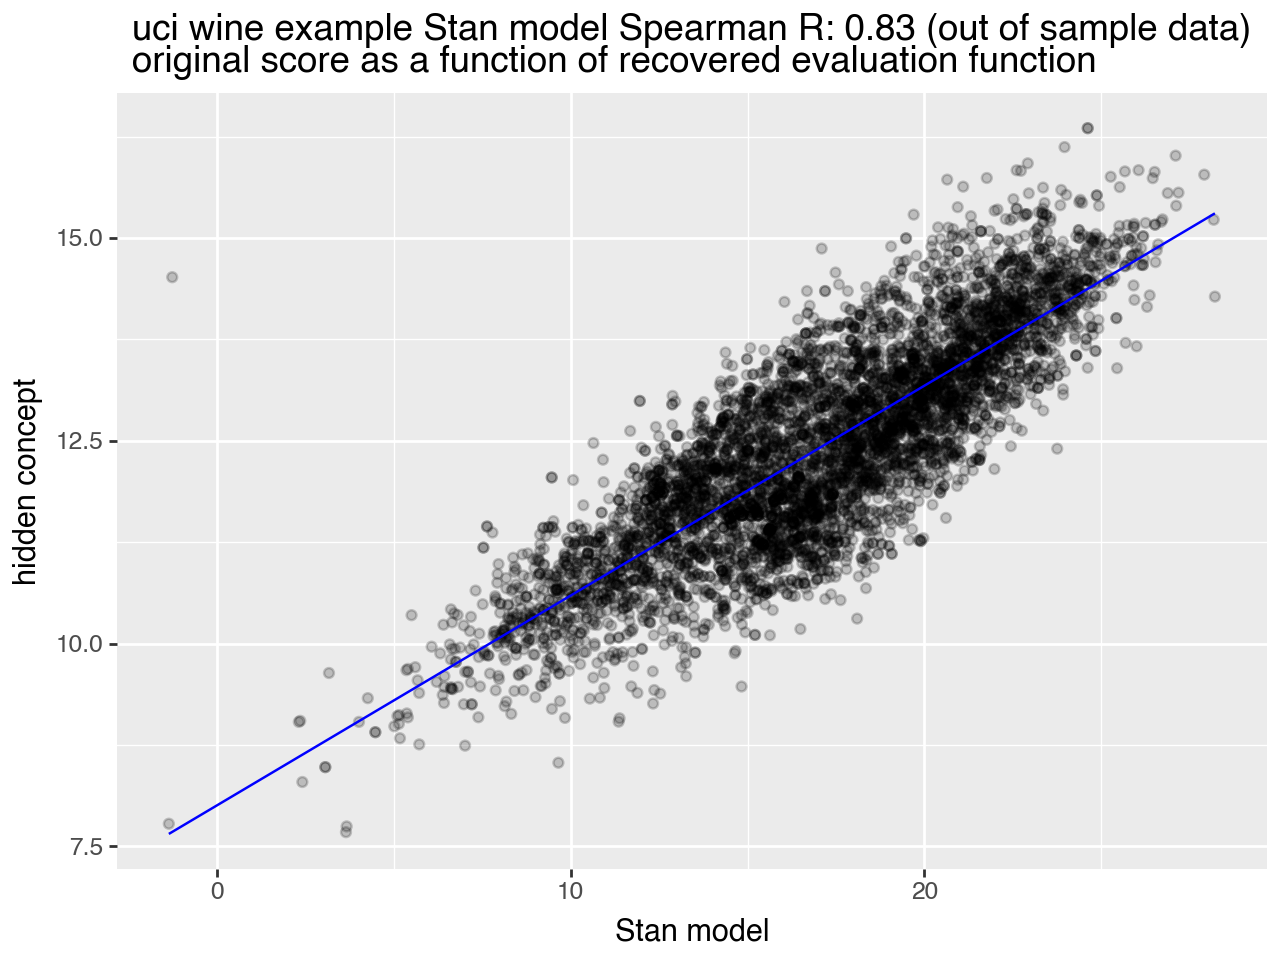

In [28]:
plot_rank_performance(
    estimated_beta=estimated_beta_Stan,               # estimated coefficients
    example_name=example_name,                        # name of data set
    n_vars=n_vars,                                    # number of non position variable
    n_alternatives=n_alternatives,                    # size of panels
    features_frame=features_frame,                    # features by row id
    observations=observations,                        # observation layout frame
    estimate_name="Stan model",                       # display name of estimate
    position_quantiles=position_quantiles,            # quantiles of estimated positions
    position_penalties=position_penalties,            # ideal position penalties
    score_compare_frame=score_compare_frame,          # score comparison frame (altered by call)
    rng=rng,                                          # pseudo random source
)


Try to approximate the Stan model with a logistic model with similar error structure.
Consider each pair of panel entries with a different outcome as an observation and try to
build a model that reproduces the observed outcomes.
The extra trick is: repeat the whole data frame negated with the outcomes reverse (so 
we don't define a problem with all positive or all negative outcomes).


In [29]:
feature_names = list(features_frame.columns) + [f'position_{sel_i}' for sel_i in range(n_alternatives)]
enc_frame = []
for row_i in range(observations.shape[0]):
     feature_row = observations.loc[row_i, :]
     sel_pick = np.argmax(
     feature_row[[f'pick_value_{sel_i}' for sel_i in range(n_alternatives)]])
     for sel_i in range(n_alternatives):
          if sel_i != sel_pick:
               posn_vec = [0] * n_alternatives
               posn_vec[sel_pick] = 1.0
               posn_vec[sel_i] = -1.0
               encoded_row = list(features_frame.loc[feature_row[f'item_id_{sel_pick}'], :] 
                    - features_frame.loc[feature_row[f'item_id_{sel_i}'], :]) + posn_vec
               di = pd.DataFrame({k: [v] for k, v in zip(feature_names, encoded_row)})
               enc_frame.append(di)
enc_frame = pd.concat(enc_frame, ignore_index=True)


In [30]:
enc_frame.head()


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,position_0,position_1,position_2,position_3,position_4
0,-0.2,-0.020,-0.01,15.30,0.006,9.0,34.0,0.00668,0.14,0.00,-1.6,-1.0,1.0,0.0,0.0,0.0
1,0.3,0.000,0.14,8.50,-0.020,5.0,-7.0,0.00074,0.10,-0.34,1.6,0.0,1.0,-1.0,0.0,0.0
2,1.3,-0.005,0.04,19.70,-0.016,16.0,-13.0,0.00480,0.08,-0.09,1.7,0.0,1.0,0.0,-1.0,0.0
3,0.3,0.000,0.09,5.00,-0.004,-6.0,-49.0,-0.00070,-0.04,-0.18,1.8,0.0,1.0,0.0,0.0,-1.0
4,2.6,-0.025,0.13,0.15,0.041,-7.0,-50.0,0.00609,0.02,0.20,-1.4,1.0,-1.0,0.0,0.0,0.0


In [31]:
logistic_model = LogisticRegression(max_iter=10000, solver='newton-cholesky')
logistic_model.fit(
    pd.concat([enc_frame, -enc_frame], ignore_index=True),
    [True] * enc_frame.shape[0] + [False] * enc_frame.shape[0],
)


LogisticRegression(max_iter=10000, solver='newton-cholesky')

estimated position influences
  position  actual effect  estimated effect
0   posn_0        -0.0000          2.370153
1   posn_1        -2.7123          1.454131
2   posn_2        -5.4246          0.348687
3   posn_3        -8.1369         -2.676188
4   posn_4       -10.8492         -1.496783


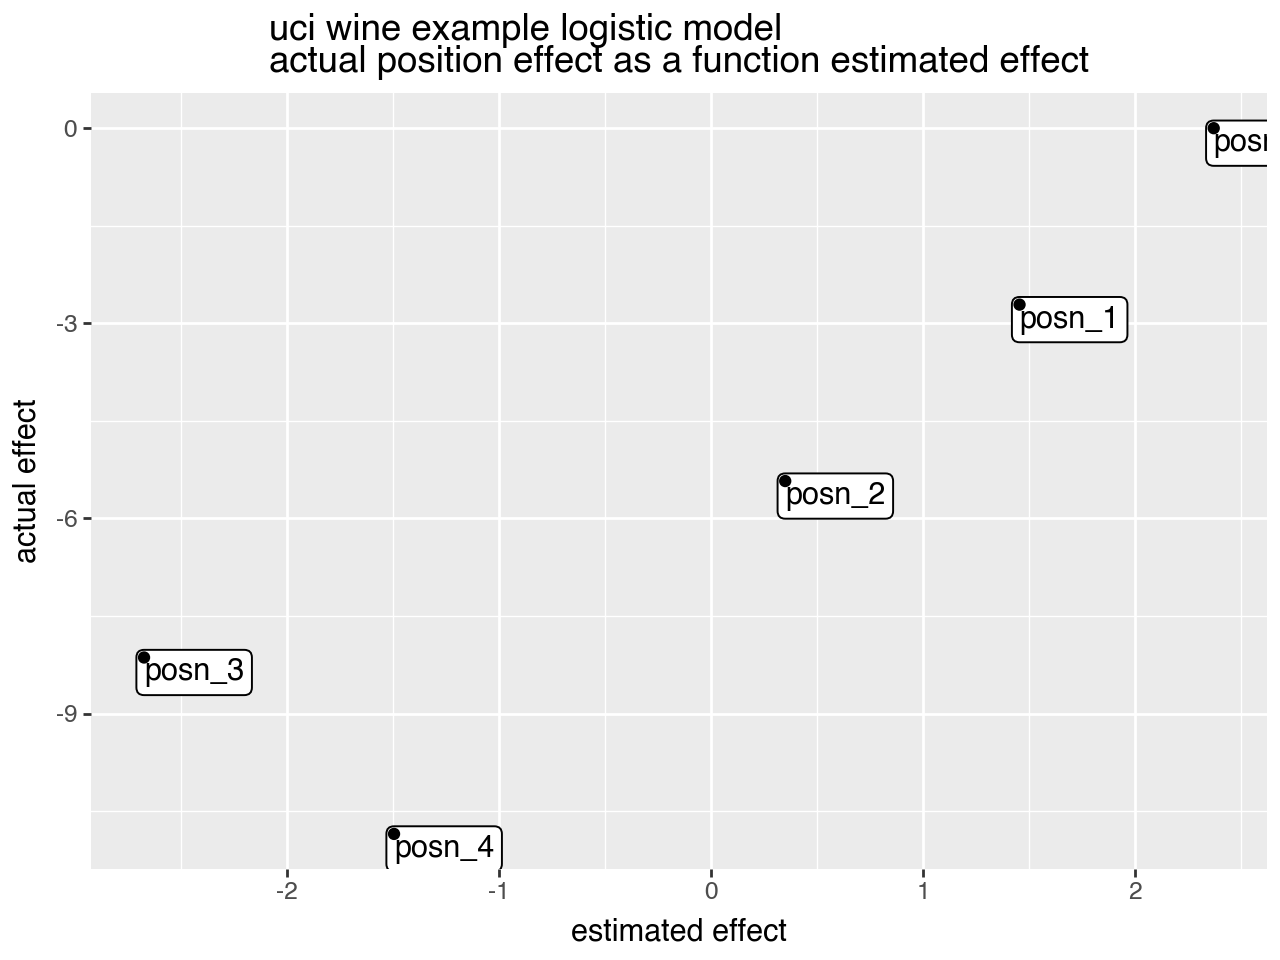

picks
   row  position  pick probability estimate  was pick
0    0         0                     0.2980     False
1    0         1                     0.2374      True
2    0         2                     0.1978     False
3    0         3                     0.1289     False
4    0         4                     0.1379     False
5    1         0                     0.2791      True
6    1         1                     0.2611     False
7    1         2                     0.2158     False
8    1         3                     0.1165     False
9    1         4                     0.1275     False


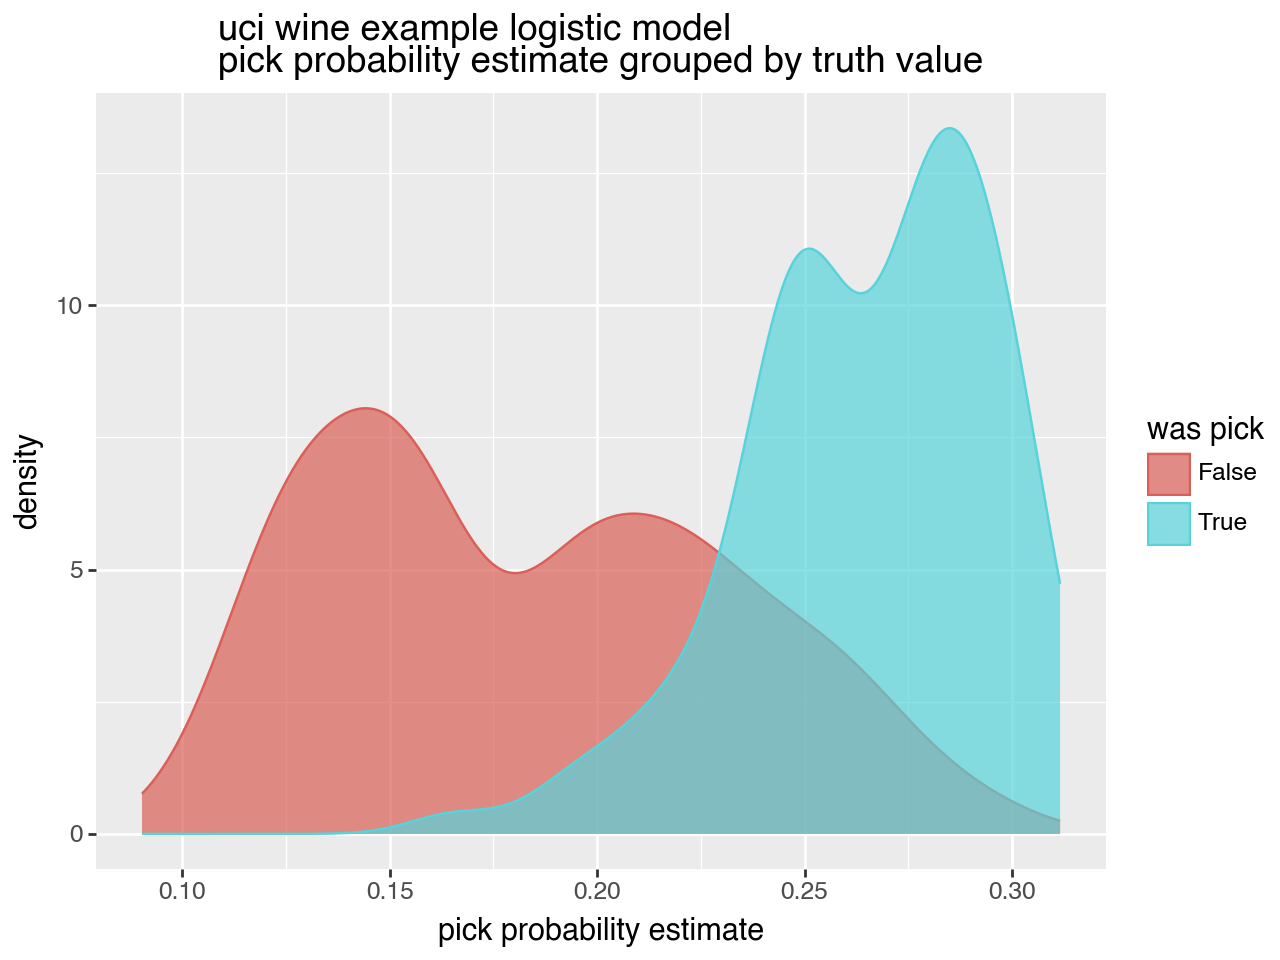

<Figure size 640x480 with 0 Axes>

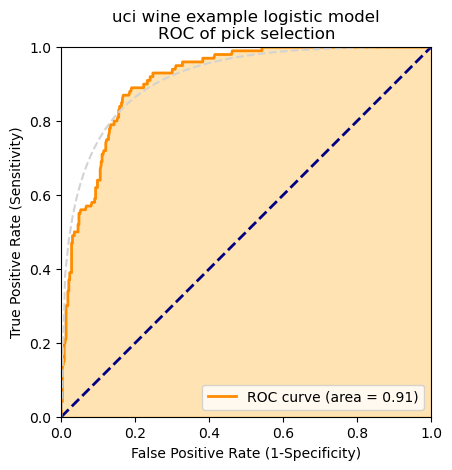

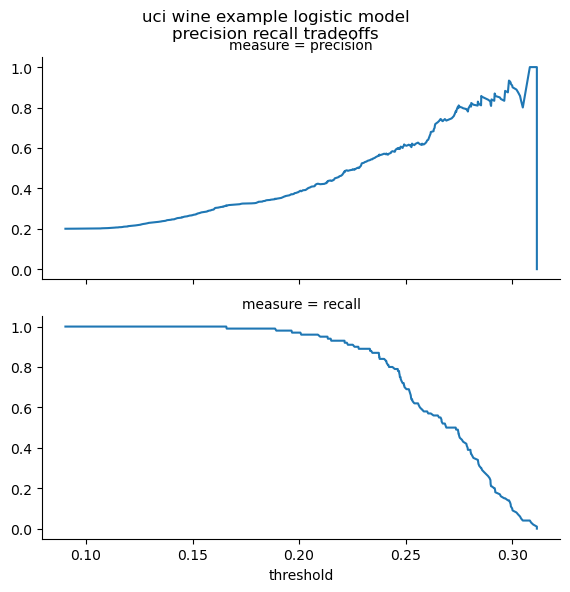

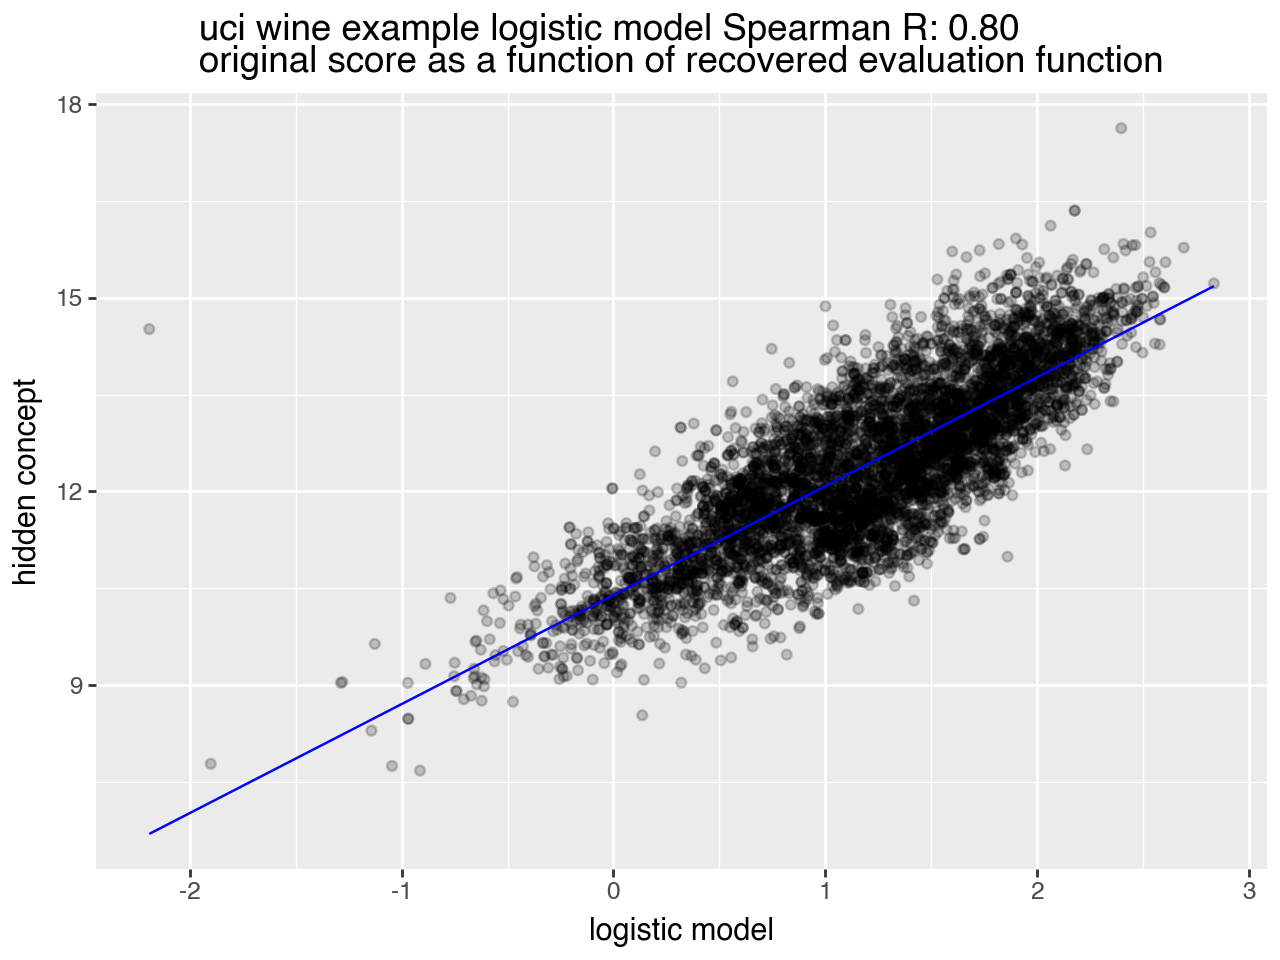

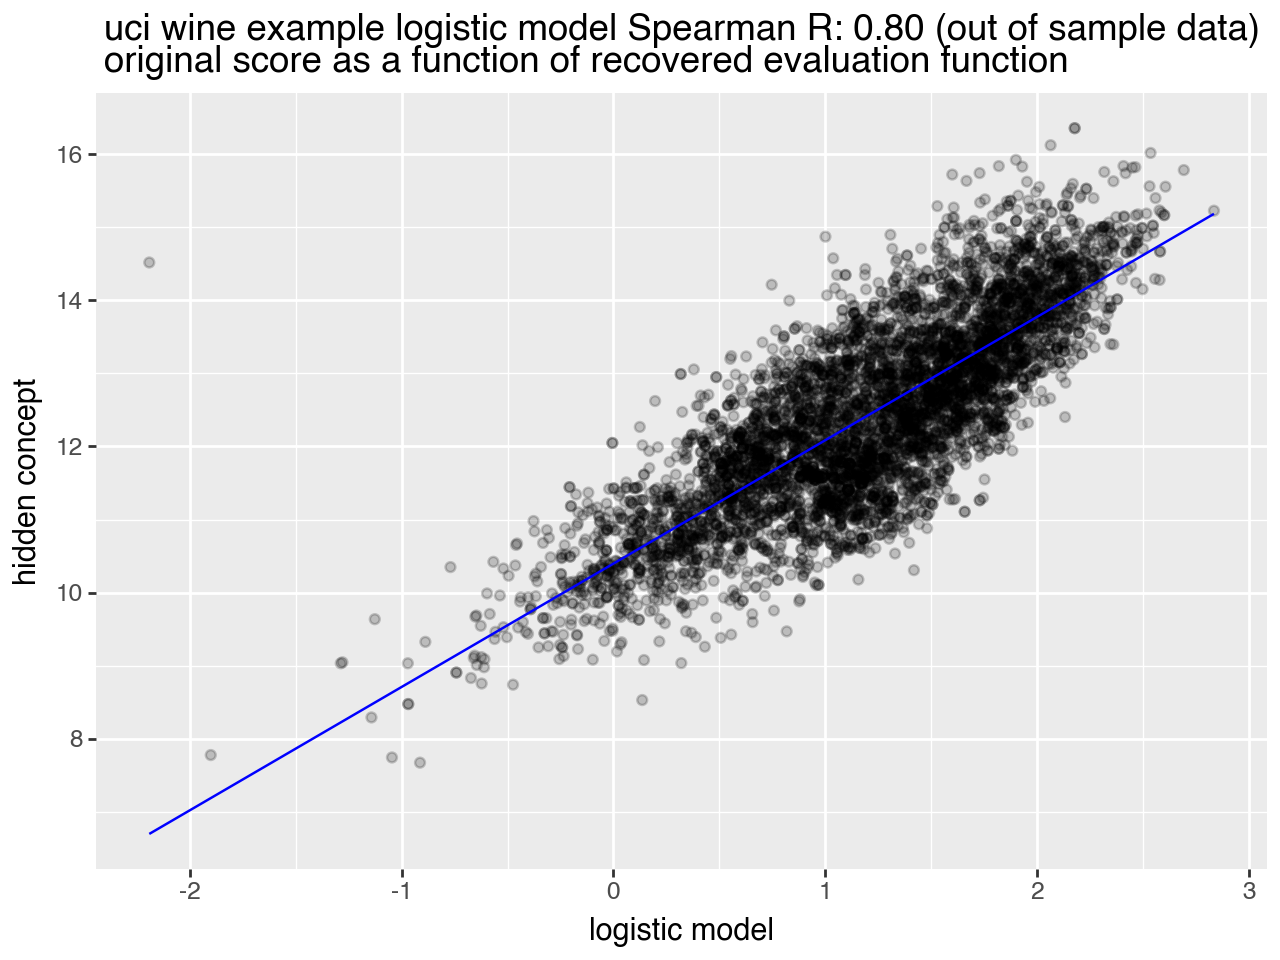

In [32]:
plot_rank_performance(
    estimated_beta=logistic_model.coef_[0],           # estimated coefficients
    example_name=example_name,                        # name of data set
    n_vars=n_vars,                                    # number of non position variable
    n_alternatives=n_alternatives,                    # size of panels
    features_frame=features_frame,                    # features by row id
    observations=observations,                        # observation layout frame
    estimate_name="logistic model",                   # display name of estimate
    position_quantiles=None,                          # quantiles of estimated positions
    position_penalties=position_penalties,            # ideal position penalties
    score_compare_frame=score_compare_frame,          # score comparison frame (altered by call)
    rng=rng,                                          # pseudo random source
)
